# Classification Project

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Import

In [89]:
churn_org = pd.read_excel('churn.xlsx')

In [90]:
churn_org.sample(5)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
6876,8212-DJRCH,1,United States,California,Newbury Park,91320,"34.172071, -118.946262",34.172071,-118.946262,Male,...,Month-to-month,Yes,Mailed check,90.35,434.5,No,0,66,4014,NaN
4662,6278-FEPBZ,1,United States,California,San Bernardino,92410,"34.106922, -117.297553",34.106922,-117.297553,Female,...,Month-to-month,No,Mailed check,20.25,186.15,No,0,68,5546,NaN
3627,3413-DHLPB,1,United States,California,Oceano,93445,"35.059695, -120.604741",35.059695,-120.604741,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.75,5969.95,No,0,53,6237,NaN
2707,1779-PWPMG,1,United States,California,San Jose,95139,"37.218705, -121.762429",37.218705,-121.762429,Female,...,Two year,Yes,Bank transfer (automatic),114.65,8333.95,No,0,29,5408,NaN
4955,8620-RJPZN,1,United States,California,Los Altos,94022,"37.349546, -122.134356",37.349546,-122.134356,Female,...,Month-to-month,No,Electronic check,20.70,20.7,No,0,68,3061,NaN


## Column exploration

In [91]:
# Identification
churn_org.shape[0]==churn_org.CustomerID.nunique() # True, Customer ID is unique to drop
churn_org.Count.nunique() # 1, All ones to drop



1

In [92]:
# Location 
churn_org['Zip Code'].nunique()>churn_org['City'].nunique()  # True, to drop city, lat_lon, Latitude, Longitude, Country, State
churn_org.Country.value_counts().values == churn_org.State.value_counts() #True - one value California
churn_org.Country.value_counts().values == churn_org.shape[0] # True - one value United States

array([ True])

In [93]:
# Customer Labels
churn_org.Gender.value_counts() # To drop, to avoid bias
churn_org['Senior Citizen'].value_counts() # To keep
churn_org['Partner'].value_counts() # yes -> married, to keep
churn_org['Dependents'].value_counts() # yes->other ppl under same address, to keep
churn_org['Contract'].value_counts() # To keep

churn_org[['Tenure Months']].describe().T # To keep, potential strong feature according to Search

,count,mean,std,min,25%,50%,75%,max
Tenure Months,7043.0,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0


In [94]:
# Services - to keep, but not to fit
# There are two main types of services - Phone, Internet
churn_org['Phone Service'].value_counts()
churn_org['Internet Service'].value_counts()

# Add on Service - Phone
churn_org['Multiple Lines'].value_counts()

# Add on Service - Internet 
churn_org['Online Security'].value_counts() 
churn_org['Online Backup'].value_counts() 
churn_org['Device Protection'].value_counts() 
churn_org['Tech Support'].value_counts() 
churn_org['Streaming TV'].value_counts() 
churn_org['Streaming Movies'].value_counts()

# Note that all recorded customer must have one of Phone/Internet Service, 
# But they may have 0 add-on service

No                     2785
Yes                    2732
No internet service    1526
Name: Streaming Movies, dtype: int64

In [95]:
# Payments - To Drop, since the customer can choose which way to pay...
# But may have an indicative power
churn_org['Paperless Billing'].value_counts()
churn_org['Payment Method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: Payment Method, dtype: int64

In [96]:
# Price - to keep
churn_org[['Monthly Charges','Total Charges']].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Monthly Charges  7043 non-null   float64
 1   Total Charges    7043 non-null   object 
dtypes: float64(1), object(1)
memory usage: 110.2+ KB


In [97]:
# Target
churn_org['Churn Label'].value_counts() 
churn_org['Churn Value'].value_counts()
# Note that Churn Label and Churn Value encodes the same information - keep one

churn_org[['Churn Score']].describe().T

,count,mean,std,min,25%,50%,75%,max
Churn Score,7043.0,58.699418,21.525131,5.0,40.0,61.0,75.0,100.0


In [98]:
# CLTV - Keep?
churn_org[['CLTV']].describe().T
#  Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. 
#  The higher the value, the more valuable the customer. High value customers should be monitored for churn.

#  CLTV should be an important indicator

,count,mean,std,min,25%,50%,75%,max
CLTV,7043.0,4400.295755,1183.057152,2003.0,3469.0,4527.0,5380.5,6500.0


Since there are 33 columns in total, it is better to: 
1. Drop the columns that is definitely not useful or contains redundant information
2. Choose the variables that is supposed to be a strong indicators and have the correlation proved to move on to model creation
3. Further improve the model by creating new features, adding extra features, deleting weak features. 

With the above structure, the following steps are carried out:
1. Drop: `CustomerID`, `Count` - as they are not useful for sure
2. Drop: `Country`, `State`, `City`, `Lat Long`, `Latitude`, `Longitude` - for encoding similar info as `Zip Code`
3. Drop: `Gender` - as it may include bias, and this is not a necessary information to be collected by the company
4. Drop: `Churn Value` - as it encodes same information as `Churn Label`
5. Drop: `Churn Reason` - as it cannot be considered as a feature
6. Explore/potental to include: `Senior Citizen`, `Partner`, `Dependents`, `Tenure Months`, `Contract`, `Monthly Charges`, `Total Charges`, `CLTV`, `Churn Score`
7. Explore/potential to manipulate: `Phone Service`, `Multiple Lines`, `Internet Service`, `Online Security`,`Online Backup`, `Device Protection`, `Tech Support`, `Streaming TV`, `Streaming Movies` - all service columns
8. Explore: `Zip Code` - as it is stated on the website that it is useful?
9. Explore if time/potential to drop: `Paperless Billing`, `Payment Method` - as customer can change those two columns easily...
10. Keep: `Churn Label` - target

In [99]:
# Create a smaller dataframe
churn_v1 = churn_org[['Churn Value', 'Churn Score',
                      'Zip Code', 'Tenure Months',
                      'Total Charges', 'CLTV','Monthly Charges', 'Contract',
                      'Senior Citizen', 'Partner', 'Dependents'
                            ]].copy()

# Encoding yes-> 1 and no->0
churn_v1.replace({'Yes':1, 'No':0}, inplace=True)

In [100]:
# Missing Value meaning in Total Charges
churn_v1[churn_v1['Total Charges']==' '] # Pass
churn_v1[churn_v1['Total Charges']!=' ']['Tenure Months'].min() # 1
# The above analysis shows that ' ' has a meaning of 0 
# as all customers with ' ' in total charges has tenure months of 0 -> no total charges

# Replace ' ' with 0
churn_v1['Total Charges'].replace({' ':0}, inplace=True)

# Convert to numeric
churn_v1['Total Charges'] = pd.to_numeric(churn_v1['Total Charges'])

# Sanity check
churn_org[churn_org['Total Charges']== ' '].shape[0] == churn_v1[churn_v1['Total Charges']== 0].shape[0] # Pass

True

In [101]:
churn_v1.sample(5)

,Churn Value,Churn Score,Zip Code,Tenure Months,Total Charges,CLTV,Monthly Charges,Contract,Senior Citizen,Partner,Dependents
3265,0,71,91701,16,1083.70,5172,69.10,Month-to-month,0,0,1
3777,0,34,94132,30,2974.50,2440,101.30,Month-to-month,1,0,1
878,1,90,90062,4,239.55,5386,50.85,Month-to-month,0,1,1
3360,0,78,92130,2,134.60,3172,60.95,Month-to-month,0,0,1
1448,1,86,92648,16,1167.80,3327,71.80,Month-to-month,1,1,0


## EDA

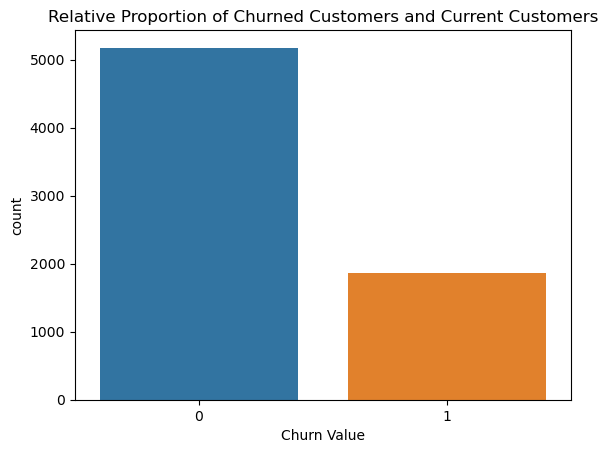

In [102]:
# Baseline if we do nothing
sns.countplot(x=churn_v1['Churn Value']);
plt.title('Relative Proportion of Churned Customers and Current Customers');
# churn_v1['Churn Value'].value_counts()# AR = 0.73, minimum goal is to have AR > 0.73

### Exploration - Numeric Features

In [103]:
# Recall Columns
cat_col_v1 = ['Senior Citizen', 'Partner','Dependents','Contract']
num_col_v1 = ['Churn Score','Tenure Months','Zip Code', 'CLTV','Total Charges','Monthly Charges']
target = ['Churn Value']

Churn Value        1.000000
Churn Score        0.664897
Tenure Months      0.352229
Total Charges      0.198324
Monthly Charges    0.193356
CLTV               0.127463
Zip Code           0.003346
Name: Churn Value, dtype: float64
******************************************************************************************************************************************************


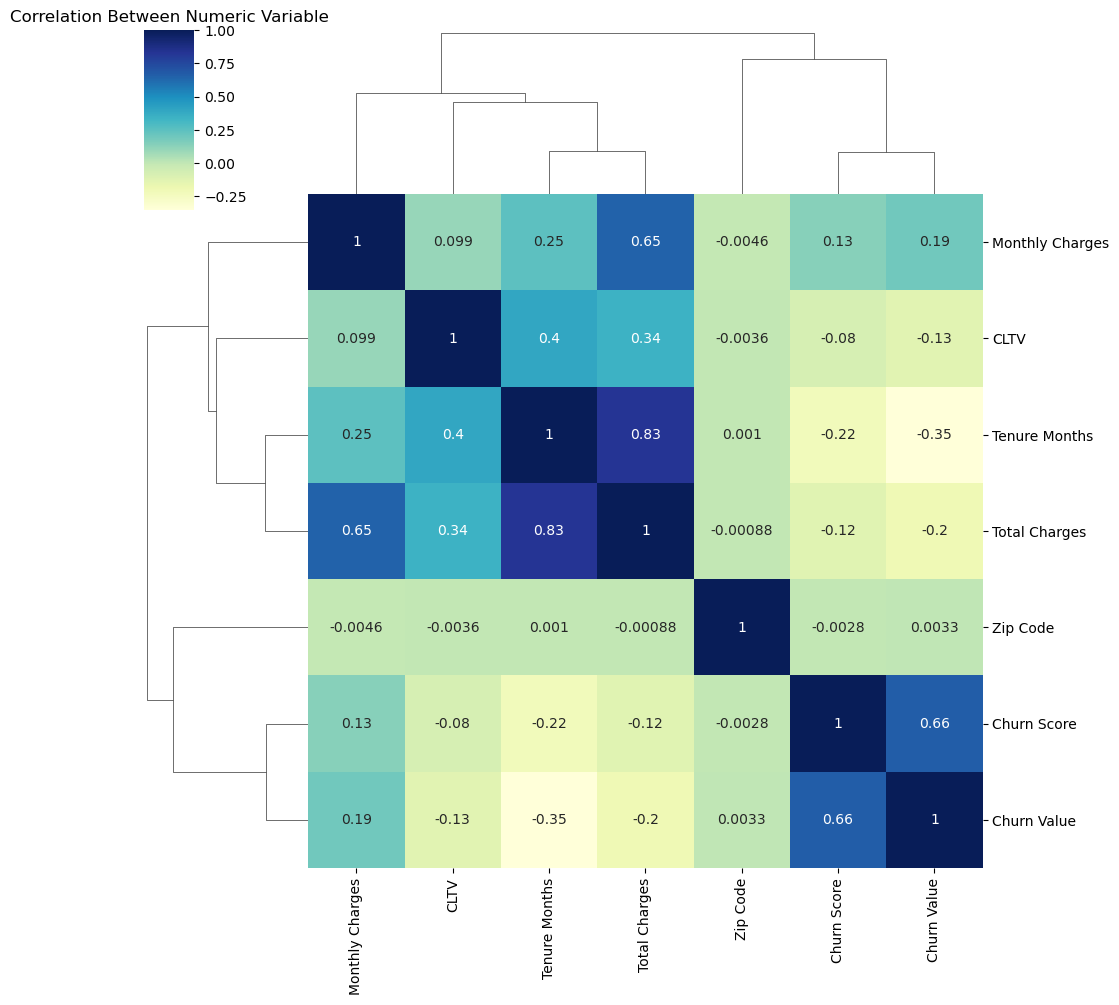

In [104]:
corr_num = churn_v1[num_col_v1+target].corr().sort_values('Churn Value')
print(abs(corr_num['Churn Value']).sort_values(ascending=False))

print('*'*150)

# Visualization
sns.clustermap(corr_num, cmap='YlGnBu', cbar=True, annot=True)
plt.title('Correlation Between Numeric Variable');

`Churn Score`, `Tenure Months` and `Total Charges` have the highest correlation with Churn Value - need further exploration.   
Since `CLTV` is such an important feature for the company (as it labels customer value), it is also further explored. 

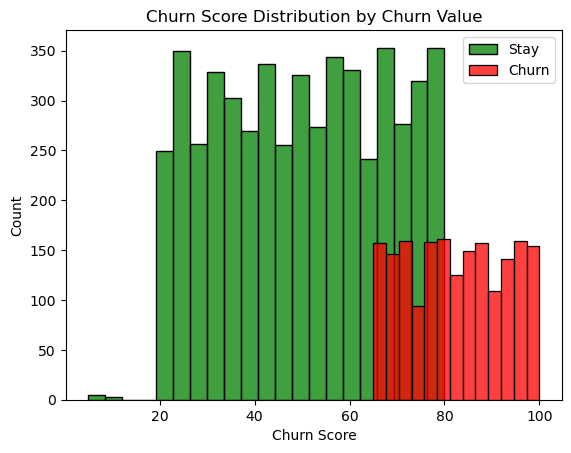

In [105]:
# Churn Score
figa, axa = plt.subplots()
sns.histplot(data = churn_v1[churn_v1['Churn Value']==0], x='Churn Score', color = 'green', label='Stay')
sns.histplot(data = churn_v1[churn_v1['Churn Value']==1], x='Churn Score', color = 'red', label='Churn')
plt.title('Churn Score Distribution by Churn Value')
axa.legend();

# Strong difference between Stay and Churn - Can do a hypothesis 
# Churned customer tend to have a big Churn Score

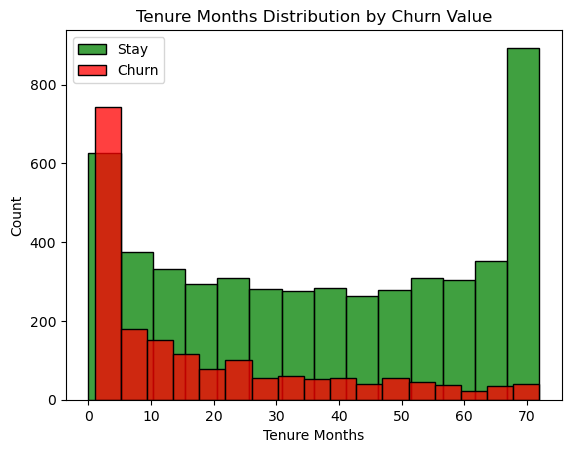

In [106]:
# Tenure Months
figb, axb = plt.subplots()
sns.histplot(data = churn_v1[churn_v1['Churn Value']==0], x='Tenure Months', color = 'green', label='Stay')
sns.histplot(data = churn_v1[churn_v1['Churn Value']==1], x='Tenure Months', color = 'red', label='Churn')
plt.title('Tenure Months Distribution by Churn Value')
axb.legend();

# New customers tend to leave

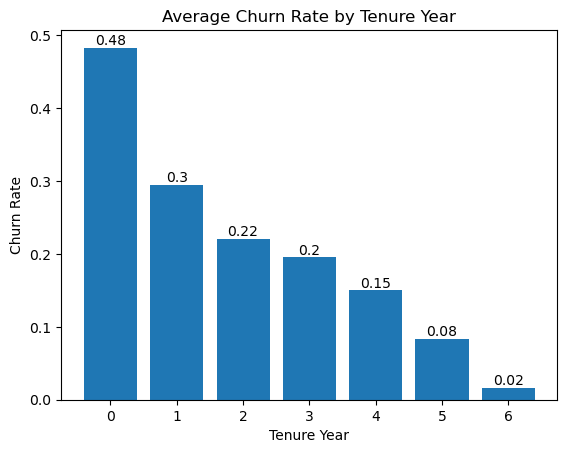

In [107]:
# Calculate Average Churn Rate by Tenure Year
t_year = churn_v1[['Churn Value','Tenure Months']].copy()
t_year['Tenure Years'] = t_year['Tenure Months']//12
t_year_sum = t_year.groupby('Tenure Years', as_index=False)['Churn Value'].mean()


figi, axi = plt.subplots()
bars = axi.bar(t_year_sum['Tenure Years'], t_year_sum['Churn Value'])

# Add y-values on top of the bars
for bar in bars:
    yval = bar.get_height()
    axi.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

axi.set_title('Average Churn Rate by Tenure Year')
axi.set_ylabel('Churn Rate')
axi.set_xlabel('Tenure Year');


Customers who has been with the companies fir kess than 1 year (0-5 Months) have the highest chance to leave. On the other hand, customers who have been with the company for longer have fewer and fewer chance to leave (i.e. Tenure Year == 6-7 -> Chance to Leave = 0.02). This suggests a need to focus on onboarding process or offering incentives for new customers to continue to stay. **It appears that once customers are retained past the initial years, they are more likely to stay for longer periods.**

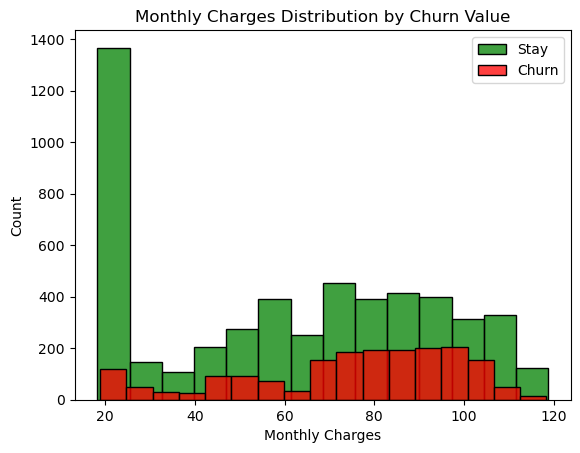

In [108]:
# Monthly Charges
figc, axc = plt.subplots()
sns.histplot(data = churn_v1[churn_v1['Churn Value']==0], x='Monthly Charges', color = 'green', label='Stay')
sns.histplot(data = churn_v1[churn_v1['Churn Value']==1], x='Monthly Charges', color = 'red', label='Churn')
plt.title('Monthly Charges Distribution by Churn Value')
axc.legend();

# Customers with monthly chargs of 70-100 tend to leave

**Colinearity between Tenure Months, Total Charges and Monthly Charges**  
It is intuitive to think that:
 $$Total \space Charges = Tenure \space Month * Monthly \space Charges$$ 
 if `Monthly Charges` stay the same (i.e. the client does not change plan and the price is stable). Below is the visualization that proves this point.

Therefore, among `Tenure Months`, `Total Charges` and `Monthly Charges`, a maximum of two can be used to create model. Since `Total Charges` is the dependent variable, it will be dropped. 

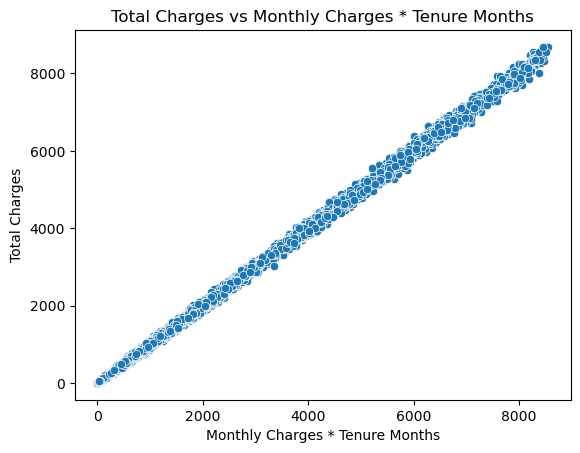

In [109]:
fige, axe = plt.subplots()
sns.scatterplot(x=churn_v1['Tenure Months']*churn_v1['Monthly Charges'],y=churn_v1['Total Charges'],ax=axe)
axe.set_title('Total Charges vs Monthly Charges * Tenure Months')
axe.set_xlabel('Monthly Charges * Tenure Months');

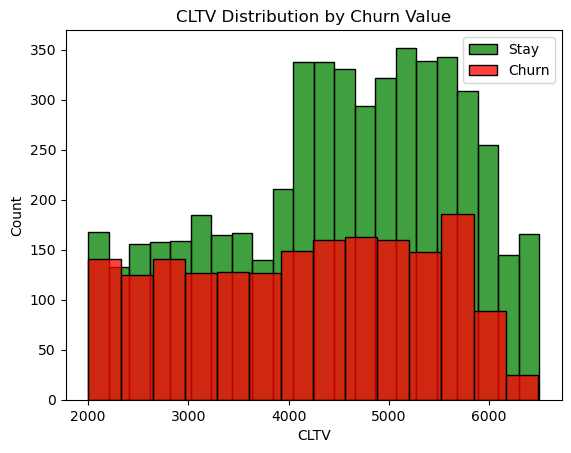

In [110]:
# CLTV
figbb, axbb = plt.subplots()
sns.histplot(data = churn_org[churn_org['Churn Value']==0], x='CLTV', color = 'green', label='Stay')
sns.histplot(data = churn_org[churn_org['Churn Value']==1], x='CLTV', color = 'red', label='Churn')
plt.title('CLTV Distribution by Churn Value')
axbb.legend();

From the above visualizations, `Churn Score`, `Monthly Charges` and `Tenure Months` will be included in the model. `CLTV` may be labeled or left out for this project. 

**Correlation between Zip Code and Tenure Value**  

Since in the data source, it pointed out that there is a clustering of client who churned on the map, although `Zip Code` did not show a strong correlation with `Churn Value`, it is worth to further explore this feeature. 

The visualization below showed that `Zip Code` has little to no power in terms of predicting `Churn Value`. Therefore, it will not be included in the model.

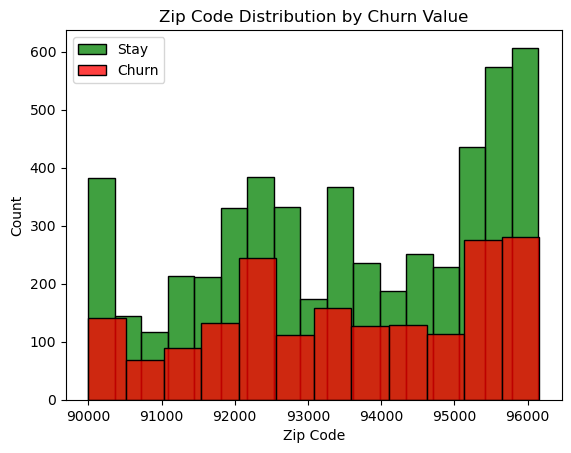

In [111]:
# Zip Code
figd, axd = plt.subplots()
sns.histplot(data = churn_v1[churn_v1['Churn Value']==0], x='Zip Code', color = 'green', label='Stay')
sns.histplot(data = churn_v1[churn_v1['Churn Value']==1], x='Zip Code', color = 'red', label='Churn')
plt.title('Zip Code Distribution by Churn Value')
axd.legend();

**Conclusion**  

`Churn Score` will be used to establish a baseline model as a reference to other models created as it has a strong indicative power of `Churn Value`. However, since `Churn Score` is based on some unknown algorithm, the risk of it is not forseeen. That means, if there is some unknown bias/overfitting issues, if the newly made model based strongly on `Churn Score`, the new model will fail in the real-world setting as well. Therefore, in the new models, `Churn Score` will not be included as a feature.   

`Tenure Months` and `Monthly Charges` will be included in the model while leaving `Total Charges` out to avoid multicollinearity issue and to increase model efficiency. 

### Exploration - Categorical Features

In [112]:
# Cat data visualiation function
def cat_visual(df, col, ax):
    '''
    This function aims to visualize the proportion of Churn vs Unchurn in different categories of a chosen column

    :param [df]: dataframe of interest
    :type [df]: pd.DataFrame

    :param [col]: columnn name of interest
    :type [col]: str

    :param [ax]: the axis to be plotted on
    :type [ax]: matplotlib.axe.Axes
    ...
    :return: the summary of Churn proportion grouped by selected column
    :rtype: pd.DataFrame
    
    '''
    summary = (df.groupby(col,as_index=False)['Churn Value'].value_counts(normalize=True))

    sns.barplot(data=summary, x=col, y='proportion', hue='Churn Value',ax=ax)
    ax.set_title(f'Churn Value Percentage by {col}')
    ax.set_ylabel('Proportion')

    return summary


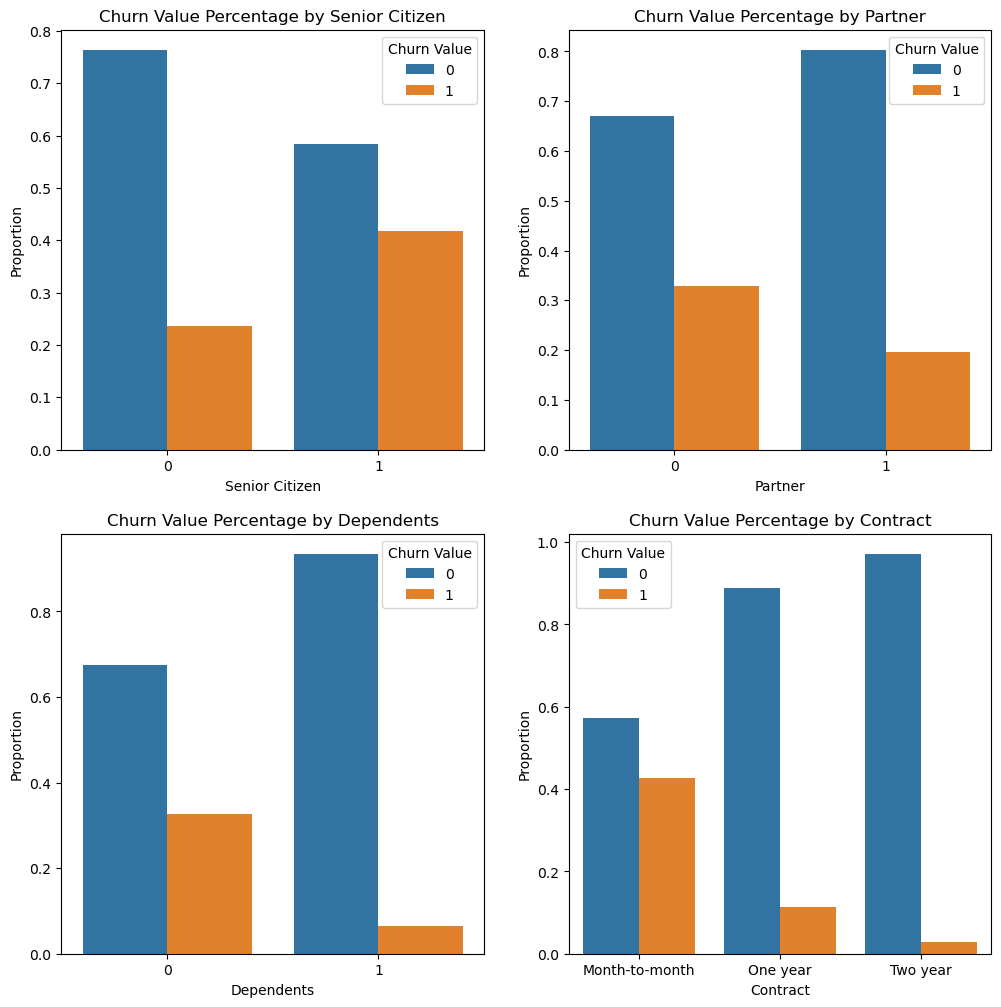

In [113]:
# Visualization
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

# Flatten the array of axes
ax1, ax2, ax3, ax4 = axs.flatten()

sum_sc = cat_visual(churn_v1,'Senior Citizen',ax=ax1)
sum_pt = cat_visual(churn_v1,'Partner',ax=ax2)
sum_dp = cat_visual(churn_v1,'Dependents',ax=ax3)
sum_ct = cat_visual(churn_v1,'Contract',ax=ax4)

Based on the above visualization, `Senior Citizen`, `Dependents` and `Contract` are selected for the initial model creation. 

## Modeling

### Function Definition

In [114]:
# Imports
# Preprocessing & Pipelines
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation imports
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score,
    precision_score,
    accuracy_score,
    make_scorer
)

In [115]:
# GridSearch/Hyperparameter Tuning
def weighted_recall_precision(y_true, y_pred): # From ChatGPT, but parameter is chosen after testing.
    recall = recall_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)

    if accuracy > 0.80: # if accuracy>0.80 is met, recall is optimized.
        # 0.80 is chosen based on personal preference...
        return recall
    else: # if there is no accuracy above 0.80, accuracy is optimized. 
        return accuracy*0.001

# According to a search
# AR > 0.85, and precision and recall both > 0.7 is considered as a good model. 
# However... few model tested in this project met the 0.8 cut-line. 

def param_tuning(X_tr, y_tr, model, param, cat_col=[], num_col=[]):
    # Doc string is writtne by ChatGPT... Thanks to ChatGPT
    # But I wrote all the functions! except for the weighted_recall_precision....
    """
    Perform hyperparameter tuning for a given model using GridSearchCV with custom scoring.

    Parameters:
    ----------
    X_tr : pandas.DataFrame
        Training feature data.
    y_tr : pandas.Series or numpy.ndarray
        Training target data.
    model : sklearn.base.BaseEstimator
        The model class (e.g., LogisticRegression, RandomForestClassifier) to be tuned.
    param : dict
        Dictionary with parameters names (str) as keys and lists of parameter settings to try as values, 
        defining the grid of hyperparameters to search.
    cat_col : list of str, optional
        List of column names corresponding to categorical features. Default is an empty list.
    num_col : list of str, optional
        List of column names corresponding to numerical features. Default is an empty list.

    Returns:
    -------
    preprocessor_t : sklearn.compose.ColumnTransformer
        The preprocessor transformer used for the best model found during GridSearchCV.
    
    Notes:
    -----
    - The function sets up a pipeline for preprocessing the data, which includes one-hot encoding for 
      categorical features and scaling for numerical features.
    - A custom scoring function (`weighted_recall_precision`) is used that prioritizes recall and accuracy 
      with specific conditions.
    - The function prints the best parameters found during GridSearchCV.
    
    Example:
    --------
    >>> from sklearn.linear_model import LogisticRegression
    >>> param = {'classifier__C': [0.1, 1, 10], 'classifier__penalty': ['l2']}
    >>> best_preprocessor = param_tuning(X_train, y_train, LogisticRegression(), param, cat_col=['cat_feature'], num_col=['num_feature'])
    >>> print(best_preprocessor)
    """


    # Define steps
    
    # Encoding
    categorical_transformer = Pipeline(
        steps=[
            ('encoder', OneHotEncoder(drop='first',sparse_output=False)),
               ("scaler", StandardScaler())
               ]
    )
    # Scaling
    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])


    # no categorical feature
    if len(cat_col) == 0:
        # Scaling only
        preprocessor_t = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, num_col)
            ]
        )





    # no numeric feature
    elif len(num_col) == 0:
        # encoding only
        preprocessor_t = ColumnTransformer(
                            transformers=[
                                ('cat', categorical_transformer, cat_col)
                            ]
        )





    # categorical feature and numeric feature both present
    else:

         # Encoding and scaling
         preprocessor_t = ColumnTransformer(
                            transformers=[
                                ('cat', categorical_transformer, cat_col),
                                ('num', numeric_transformer, num_col)
            ]
        )





    # Instance of model
    model = Pipeline(
        steps=[("preprocessor_t", preprocessor_t), ('classifier', model)]
                    )
    
    # Define the custom scorer
    custom_scorer = make_scorer(weighted_recall_precision)
    grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, scoring=custom_scorer)

    # Gridsearch
    grid_search.fit(X_tr, y_tr)

    print("Best parameters found: ", grid_search.best_params_)

    return preprocessor_t

In [116]:
# Testing
def testing(X_tr, y_tr, X_te, y_te, model, preprocessor):
  '''
  Perform training and testing for a given model with optimized hyperparamters. 

  Parameters:
  ----------
  X_tr : pandas.DataFrame
      Training feature data.
  y_tr : pandas.Series or numpy.ndarray
      Training target data.
  X_te : pandas.DataFrame
      Testing feature data.
  y_te : pandas.Series or numpy.ndarray
      Testing target data.
  model : sklearn.base.BaseEstimator
      The model class with tuned hyperparameter(e.g., LogisticRegression, RandomForestClassifier) to be trained and tested.
  preprocessor_t : sklearn.compose.ColumnTransformer
    The preprocessor transformer used for the best model found during GridSearchCV.
  
  Returns:
  -------
  y_pr : pandas.DataFrame
      Predicted target values.

  '''
  model_f = Pipeline(
  steps=[("preprocessor_t", preprocessor), ('classifier', model)])

  model_f.fit(X_tr, y_tr)
  y_pr = model_f.predict(X_te)

  return y_pr

In [117]:
# Evaluation
def evaluating(y_pr,y_te):
    '''
    The function displays a confusion matrix and prints a classification report with given data.

    Parameters:
    ----------
    y_pr : pandas.Series or numpy.ndarray
        Predicted target data.
    y_te : pandas.Series or numpy.ndarray
        Testing target data.
    '''

    # Label names for confusion matrix
    labels = np.array([0, 1], dtype=np.int64)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_te, y_pr), display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(y_te, y_pr))

### Baseline Model with Churn Score

Since `Churn Score` has a strong correlation with `Churn Value`, it is used to establish a baseline model. 

In [118]:
# Feature & Target Split
X_bsl = churn_v1[['Churn Score']]
y_bsl = churn_v1['Churn Value']

# Train Test Split
X_train_bsl, X_test_bsl, y_train_bsl, y_test_bsl = train_test_split(X_bsl, y_bsl, test_size=0.1, stratify=y_bsl, random_state=1144)

# Define numeric & categorical col
numeric_col_bsl = ['Churn Score']
categorical_col_bsl = []

#### SVC

In [119]:
# Define grid search parameters
param_grid_svc_bsl = {
    'classifier__class_weight':['balanced',None],
    'classifier__C':[0.1, 0.01, 1],
    'classifier__gamma' : [0.01, 0.1, 1],
    'classifier__kernel': ['rbf','linear']
}

# Tuning
preprocessor_svc_bsl = param_tuning(X_train_bsl,y_train_bsl, SVC(),param_grid_svc_bsl,cat_col=categorical_col_bsl,num_col=numeric_col_bsl)

Best parameters found:  {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}


In [120]:
# Training & testing
model_svc_bsl = SVC(
                        C=0.01, 
                        class_weight = 'balanced',
                        gamma=0.01, 
                        kernel='linear'
                                        )
y_pred_svc_bsl = testing(X_train_bsl,y_train_bsl,X_test_bsl,y_test_bsl, model=model_svc_bsl, preprocessor=preprocessor_svc_bsl)

#### Logistic Regression

In [121]:
# Define grid search parameters
param_grid_lgr_bsl = {
    'classifier__class_weight':['balanced',None],
    'classifier__C':[0.1, 0.01, 1, 0.03,0.04,0.02],
}

# Tuning
preprocessor_lgr_bsl = param_tuning(X_train_bsl,y_train_bsl, LogisticRegression(),param_grid_lgr_bsl,cat_col=categorical_col_bsl,num_col=numeric_col_bsl)

Best parameters found:  {'classifier__C': 0.01, 'classifier__class_weight': 'balanced'}


In [122]:
# Training & testing
model_lgr_bsl = LogisticRegression(
                        C=0.03, 
                        class_weight = 'balanced',
                                        )
y_pred_lgr_bsl = testing(X_train_bsl,y_train_bsl,X_test_bsl,y_test_bsl, model=model_lgr_bsl, preprocessor=preprocessor_lgr_bsl)

#### KNN

In [123]:
# Define grid search parameters
param_grid_knn_bsl = {
    'classifier__n_neighbors':[5,15,20,25,30,50,100,200],
    'classifier__weights':['uniform','distance'],
}

# Tuning
preprocessor_knn_bsl = param_tuning(X_train_bsl,y_train_bsl, KNeighborsClassifier(),param_grid_knn_bsl,cat_col=categorical_col_bsl,num_col=numeric_col_bsl)

Best parameters found:  {'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}


In [124]:
# Training & testing
model_knn_bsl  =KNeighborsClassifier(
                        n_neighbors=15, 
                        weights = 'uniform',
                                        )
y_pred_knn_bsl = testing(X_train_bsl,y_train_bsl,X_test_bsl,y_test_bsl, model=model_knn_bsl, preprocessor=preprocessor_knn_bsl)

#### Evaluation & Comparison of three models

SVC Model Evaluation


<Figure size 800x600 with 0 Axes>

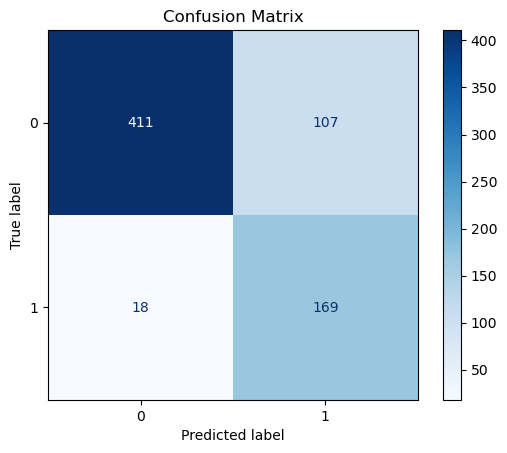

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       518
           1       0.61      0.90      0.73       187

    accuracy                           0.82       705
   macro avg       0.79      0.85      0.80       705
weighted avg       0.87      0.82      0.83       705

****************************************************************************************************
Logistic Regression Model Evaluation


<Figure size 800x600 with 0 Axes>

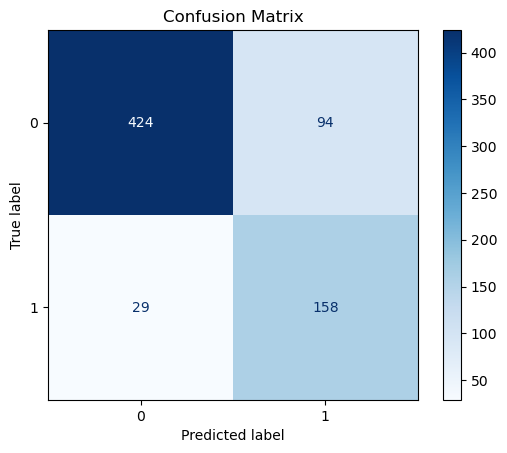

              precision    recall  f1-score   support

           0       0.94      0.82      0.87       518
           1       0.63      0.84      0.72       187

    accuracy                           0.83       705
   macro avg       0.78      0.83      0.80       705
weighted avg       0.85      0.83      0.83       705

****************************************************************************************************
KNN Model Evaluation


<Figure size 800x600 with 0 Axes>

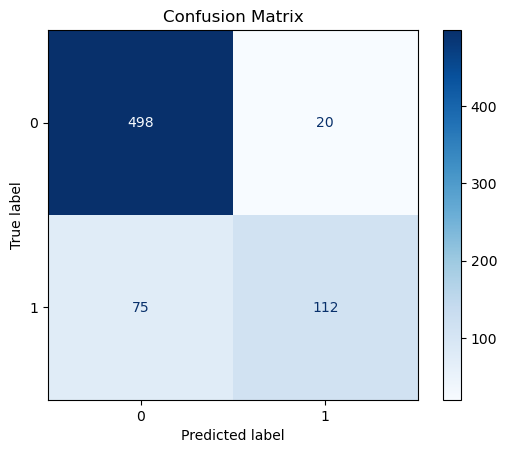

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       518
           1       0.85      0.60      0.70       187

    accuracy                           0.87       705
   macro avg       0.86      0.78      0.81       705
weighted avg       0.86      0.87      0.86       705



In [125]:
print('SVC Model Evaluation')
evaluating(y_pred_svc_bsl,y_test_bsl)


print('*'*100)
print('Logistic Regression Model Evaluation')
evaluating(y_pred_lgr_bsl,y_test_bsl)

print('*'*100)
print('KNN Model Evaluation')
evaluating(y_pred_knn_bsl,y_test_bsl)

By using only `Churn Score` as an feature for `Churn Value` prediction, the accuracy rate is around 0.85. It is really a reliable model. However as stated before, since the underlying algorithm is unknown, there is risk of it having overfitting issue with this given dataset or some other unknown issue. `Churn Score` will not be used as a feature in the following model creation. 

Definitely all three models predicts better than the case where we did nothing (0.73). Among three of them KNN has nailed it. However, since the functions and pipelines are so easy, I will continue to test all three of them with chosen features

### Model 2 - To include strongest features
Based on the correlation analysis the following columns are selected to create this model:
 `Tenure Months`,`Senior Citizen`, `Dependents`,`Contract`,`Monthly Charges`,`CLTV`

In [126]:
# Feature & Target Split
X_m2 = churn_v1[['Tenure Months','Senior Citizen', 'Dependents','Contract','Monthly Charges','CLTV']]
y_m2 = churn_v1['Churn Value']

# Train Test Split
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_m2, y_m2, test_size=0.1, stratify=y_m2,random_state=1144)

# Define numeric & categorical col
numeric_col_m2 = ['Tenure Months','Monthly Charges','CLTV']
categorical_col_m2= ['Senior Citizen', 'Dependents','Contract']

#### SVC

In [127]:
# Define grid search parameters
param_grid_svc_m2 = {
    'classifier__class_weight':['balanced',None],
    'classifier__C':[0.1, 0.01, 1],
    'classifier__gamma' : [0.01, 0.1, 1],
    'classifier__kernel': ['rbf']
}

# Tuning
preprocessor_svc_m2 = param_tuning(X_train_m2,y_train_m2, SVC(),param_grid_svc_m2,cat_col=categorical_col_m2,num_col=numeric_col_m2)

Best parameters found:  {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}


In [128]:
# Training & testing
model_svc_m2 = SVC(
                        C=1, 
                        class_weight = None,
                        gamma=1, 
                        kernel='rbf'
                                        )
y_pred_svc_m2 = testing(X_train_m2,y_train_m2,X_test_m2,y_test_m2, model=model_svc_m2, preprocessor=preprocessor_svc_m2)

SVC Model Evaluation


<Figure size 800x600 with 0 Axes>

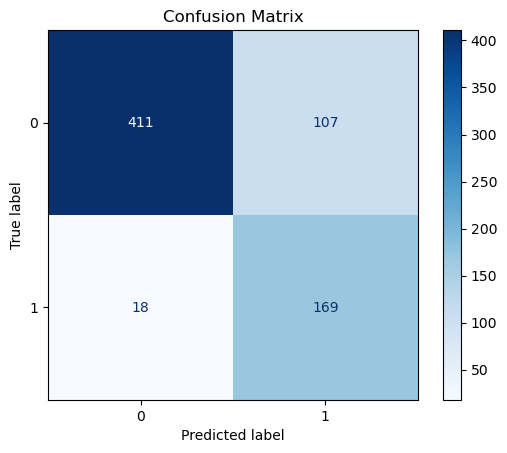

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       518
           1       0.61      0.90      0.73       187

    accuracy                           0.82       705
   macro avg       0.79      0.85      0.80       705
weighted avg       0.87      0.82      0.83       705

****************************************************************************************************
SVC Model 2 Evaluation


<Figure size 800x600 with 0 Axes>

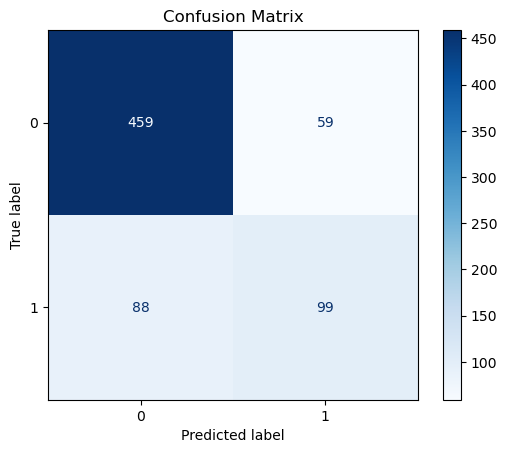

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       518
           1       0.63      0.53      0.57       187

    accuracy                           0.79       705
   macro avg       0.73      0.71      0.72       705
weighted avg       0.78      0.79      0.79       705



In [129]:
# Evaluating
print('SVC Model Evaluation') 
evaluating(y_pred_svc_bsl,y_test_bsl)

print('*'*100)
print('SVC Model 2 Evaluation')
evaluating(y_pred_svc_m2,y_test_m2) 

#### Logistic Regression

In [130]:
# Define grid search parameters
param_grid_lgr_m2 = {
    'classifier__class_weight':['balanced',None],
    'classifier__C':[0.1, 0.01, 1,0.001],
}

# Tuning
preprocessor_lgr_m2 = param_tuning(X_train_m2,y_train_m2, LogisticRegression(),param_grid_lgr_m2,cat_col=categorical_col_m2,num_col=numeric_col_m2)

Best parameters found:  {'classifier__C': 1, 'classifier__class_weight': None}


In [131]:
# Training & testing
model_lgr_m2 = LogisticRegression(
                        C=1, 
                        class_weight = None,
                                        )
y_pred_lgr_m2 = testing(X_train_m2,y_train_m2,X_test_m2,y_test_m2, model=model_lgr_m2, preprocessor=preprocessor_lgr_m2)

Logistic Regression Model Evaluation


<Figure size 800x600 with 0 Axes>

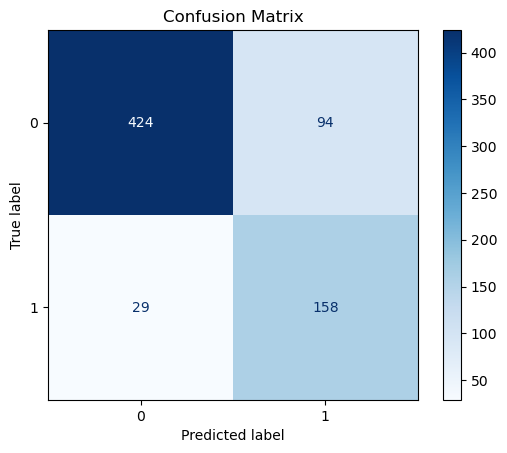

              precision    recall  f1-score   support

           0       0.94      0.82      0.87       518
           1       0.63      0.84      0.72       187

    accuracy                           0.83       705
   macro avg       0.78      0.83      0.80       705
weighted avg       0.85      0.83      0.83       705

****************************************************************************************************
Logistic Regression Model 2 Evaluation


<Figure size 800x600 with 0 Axes>

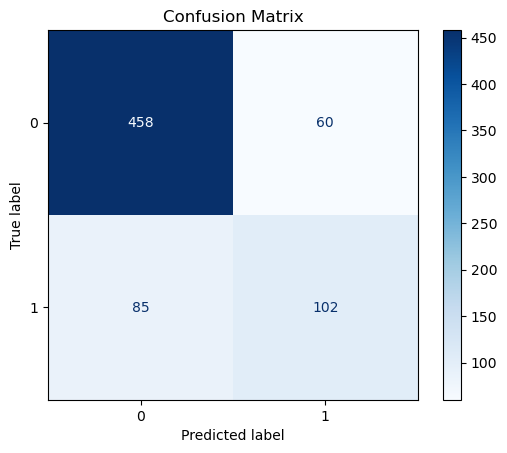

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       518
           1       0.63      0.55      0.58       187

    accuracy                           0.79       705
   macro avg       0.74      0.71      0.72       705
weighted avg       0.79      0.79      0.79       705



In [132]:
# Evaluating - worse
print('Logistic Regression Model Evaluation')
evaluating(y_pred_lgr_bsl,y_test_bsl)

print('*'*100)
print('Logistic Regression Model 2 Evaluation')
evaluating(y_pred_lgr_m2,y_test_m2) 

Overall Better

#### KNN

In [133]:
# Define grid search parameters
param_grid_knn_m2 = {
    'classifier__n_neighbors':[5,15,20,25,30,50,100,200],
    'classifier__weights':['uniform','distance'],
}

# Tuning
preprocessor_knn_m2 = param_tuning(X_train_m2,y_train_m2, KNeighborsClassifier(),param_grid_knn_m2,cat_col=categorical_col_m2,num_col=numeric_col_m2)

Best parameters found:  {'classifier__n_neighbors': 25, 'classifier__weights': 'uniform'}


In [134]:
# Training & testing
model_knn_m2  =KNeighborsClassifier(
                        n_neighbors=25, 
                        weights = 'uniform',
                                        )
y_pred_knn_m2 = testing(X_train_m2,y_train_m2,X_test_m2,y_test_m2, model=model_knn_m2, preprocessor=preprocessor_knn_m2)

KNN Model Evaluation


<Figure size 800x600 with 0 Axes>

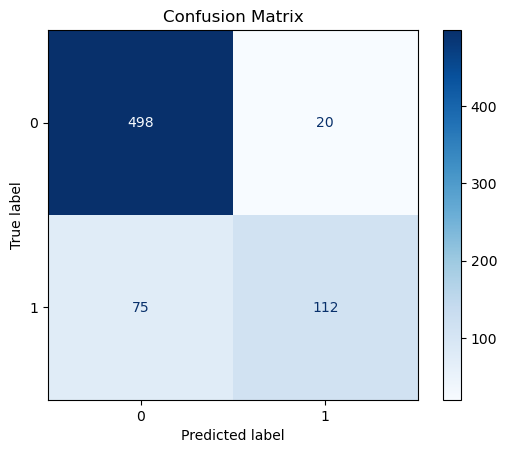

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       518
           1       0.85      0.60      0.70       187

    accuracy                           0.87       705
   macro avg       0.86      0.78      0.81       705
weighted avg       0.86      0.87      0.86       705

****************************************************************************************************
KNN Model 2 Evaluation


<Figure size 800x600 with 0 Axes>

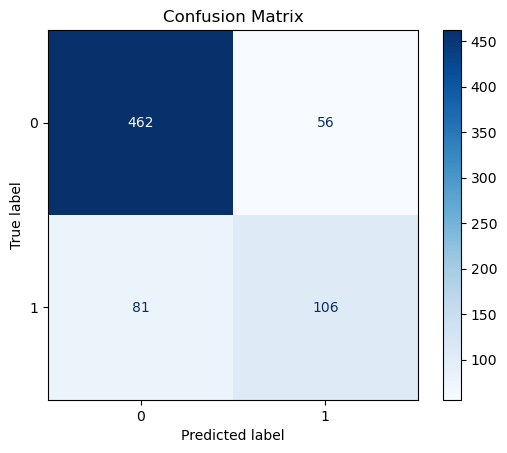

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       518
           1       0.65      0.57      0.61       187

    accuracy                           0.81       705
   macro avg       0.75      0.73      0.74       705
weighted avg       0.80      0.81      0.80       705



In [135]:
# Evaluating
print('KNN Model Evaluation')
evaluating(y_pred_knn_bsl,y_test_bsl)

print('*'*100)
print('KNN Model 2 Evaluation')
evaluating(y_pred_knn_m2,y_test_m2) 

The performance is reduced in every aspect which is expected as the most indicative field was removed from the model. 
For Model 2 with  `Tenure Months`,`Senior Citizen`, `Dependents`,`Contract`,`Monthly Charges`,`CLTV`, the three model performed almost the same. However, SVC model took the most time. 

### Model 3 - To include service features

There are 9 columns of service features. Among the 9 services, `Phone Service` and `Internet Service` are the two main services offered by the company, each having its own add-on features that customers can choose whether or not to use. 



Add on service of `Phone Service`: `Multiple Lines`  
Add on services of `Internet Service`: `Online Security`,`Online Backup`, `Device Protection`, `Tech Support`, `Streaming TV`, `Streaming Movies`

Please note that in each of the add-on service, customers are put into three categories: 
`Yes` -> customer uses the service,  
`No` -> customer does use the service,  
and `No Internet/Phone service` -> Not Applicable. 

Therefore, if `OHE` is used to transform and fit all the columns relating to services, there will be overlapping columns.  
For example, InternetService_No will essentially be the same as Onlinebackup_NoInternet.  
When this happens, it will bring a multicollinearity issue for Logistic Regression and reduce model effiency. 

#### Data Cleaning

In [136]:
service12 = churn_org[['Internet Service','Phone Service']].replace({'No':0,'Yes':1, 'Fiber optic':1, 'DSL':1}) # Main service

service_phone = churn_org[['Multiple Lines']].replace({'No':0,'Yes':1, 'No internet service':0, 'No phone service':0}) # Add on for phone

service_internet = churn_org [[
                                'Online Security','Online Backup',
                                'Device Protection','Tech Support',
                                'Streaming TV','Streaming Movies'
                                ]].replace({'No':0,'Yes':1, 'No internet service':0, 'No phone service':0}) # Add on for internet

In [137]:
# Creation of churn_v2 to include more service Features
churn_v2 = churn_v1.copy().join(service12).join(service_phone).join(service_internet)
churn_v2['# of Add-on Phone'] = service_phone.sum(axis=1)
churn_v2['# of Add-on Internet'] = service_internet.sum(axis=1)
churn_v2.sample(5)

,Churn Value,Churn Score,Zip Code,Tenure Months,Total Charges,CLTV,Monthly Charges,Contract,Senior Citizen,Partner,...,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,# of Add-on Phone,# of Add-on Internet
2994,0,70,95975,3,293.15,2813,95.40,Month-to-month,0,0,...,1,0,0,1,0,0,1,1,0,3
6414,0,28,95366,54,1031.10,5548,18.95,Two year,1,1,...,1,0,0,0,0,0,0,0,0,0
2846,0,42,95549,71,1710.15,4015,24.65,Two year,0,1,...,1,1,0,0,0,0,0,0,1,0
1199,1,80,95426,27,2287.25,5172,85.25,Month-to-month,1,0,...,1,1,0,0,0,0,0,1,1,1
1690,1,84,95742,41,4213.35,2098,102.60,One year,0,1,...,1,1,0,0,1,1,1,1,1,4


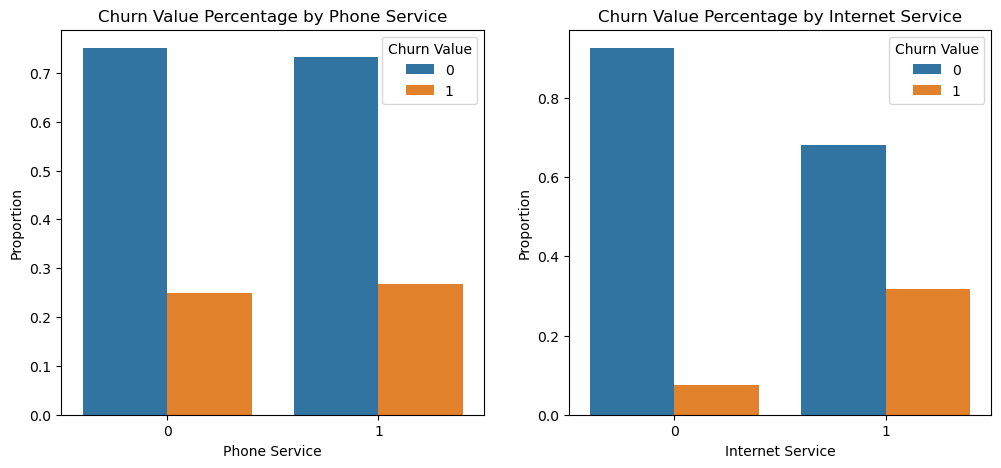

In [138]:
figt, (axt,axz) = plt.subplots(ncols=2, figsize=(12,5))
sum_ps = cat_visual(churn_v2,'Phone Service', ax=axt) 
sum_is = cat_visual(churn_v2,'Internet Service', ax=axz) 

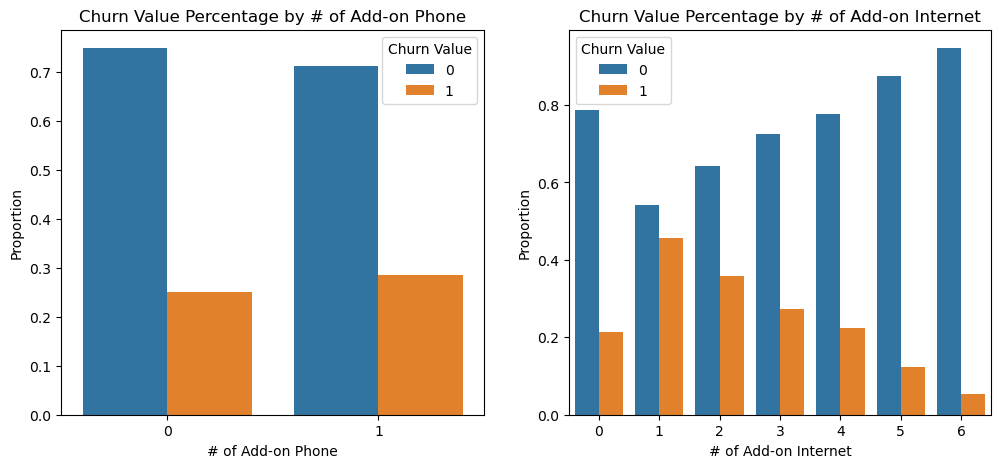

In [139]:
figs, (axs,axu) = plt.subplots(ncols=2, figsize=(12,5))
sum_ps_ad = cat_visual(churn_v2,'# of Add-on Phone', ax=axs) 
sum_is_ad = cat_visual(churn_v2,'# of Add-on Internet', ax=axu) # Add on internet has a predictive power altho not linear

`Internet Service` and `Phone Service` is chosen to be included in Model 3 as these are the two main services offered by the company. 

In [140]:
# Feature & Target Split
X_m3 = churn_v2[['Tenure Months','Senior Citizen', 'Dependents','Contract', 'Monthly Charges','Internet Service','Phone Service','CLTV']]
y_m3 = churn_v2['Churn Value']

# Train Test Split
X_train_m3, X_test_m3, y_train_m3, y_test_m3 = train_test_split(X_m3, y_m3, test_size=0.1, stratify=y_m3, random_state=1144)

# Define numeric & categorical col
numeric_col_m3 = ['Tenure Months','Monthly Charges', 'CLTV']
categorical_col_m3= ['Senior Citizen', 'Dependents','Contract','Internet Service', 'Phone Service']

#### SVC - SVC to this point is too slow, so it is out

In [141]:
# # Define grid search parameters
# param_grid_svc_m3 = {
#     'classifier__class_weight':['balanced',None],
#     'classifier__C':[0.1, 0.01, 1],
#     'classifier__gamma' : [0.01, 0.1, 1],
#     'classifier__kernel': ['rbf']
# }

# # Tuning
# preprocessor_svc_m3 = param_tuning(X_train_m3,y_train_m3, SVC(),param_grid_svc_m3,cat_col=categorical_col_m3,num_col=numeric_col_m3)

In [142]:
# # Training & testing
# model_svc_m3 = SVC(
#                         C=1, 
#                         class_weight = None,
#                         gamma=0.01, 
#                         kernel='rbf'
#                                         )
# y_pred_svc_m3 = testing(X_train_m3,y_train_m3,X_test_m3,y_test_m3, model=model_svc_m3, preprocessor=preprocessor_svc_m3)

In [143]:
# # Evaluating
# print('SVC Model Evaluation')
# evaluating(y_pred_svc_bsl,y_test_bsl)

# print('*'*100)
# print('SVC Model 2 Evaluation')
# evaluating(y_pred_svc_m2,y_test_m2) 

# print('*'*100)
# print('SVC Model 2 Evaluation')
# evaluating(y_pred_svc_m3,y_test_m3) 

Note that CLTV is removed here because it would vastly reduce the model performance. 

#### Logistic Regression

In [144]:
# Define grid search parameters
param_grid_lgr_m3 = {
    'classifier__class_weight':['balanced',None],
    'classifier__C':[0.1, 0.5, 1,0.01,0.001],
}

# Tuning
preprocessor_lgr_m3 = param_tuning(X_train_m3,y_train_m3, LogisticRegression(),param_grid_lgr_m3,cat_col=categorical_col_m3,num_col=numeric_col_m3)

Best parameters found:  {'classifier__C': 0.1, 'classifier__class_weight': None}


In [145]:
# Training & testing
model_lgr_m3 = LogisticRegression(
                        C=0.1, 
                        class_weight = None,
                                        )
y_pred_lgr_m3 = testing(X_train_m3,y_train_m3,X_test_m3,y_test_m3, model=model_lgr_m3, preprocessor=preprocessor_lgr_m3)

Logistic Regression Model 2 Evaluation


<Figure size 800x600 with 0 Axes>

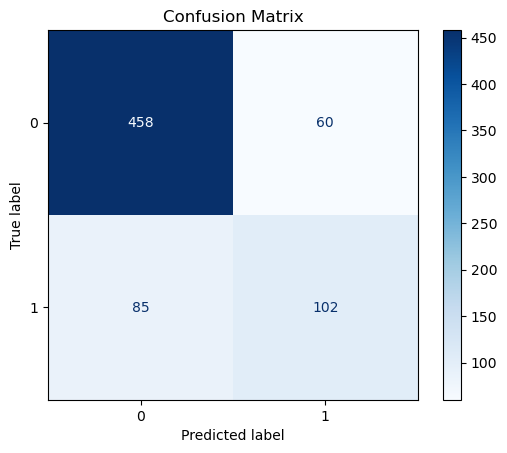

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       518
           1       0.63      0.55      0.58       187

    accuracy                           0.79       705
   macro avg       0.74      0.71      0.72       705
weighted avg       0.79      0.79      0.79       705

****************************************************************************************************
Logistic Regression Model 3 Evaluation


<Figure size 800x600 with 0 Axes>

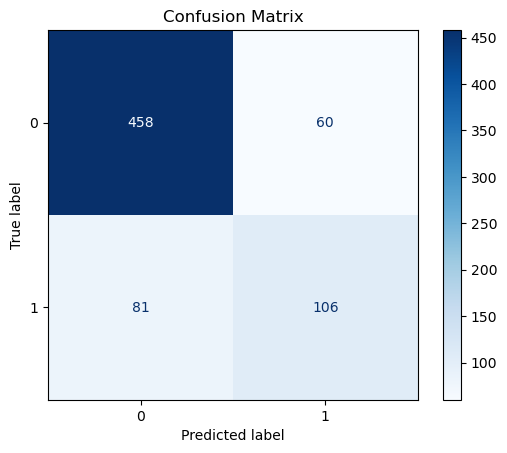

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       518
           1       0.64      0.57      0.60       187

    accuracy                           0.80       705
   macro avg       0.74      0.73      0.73       705
weighted avg       0.79      0.80      0.80       705



In [146]:
# Evaluating
print('Logistic Regression Model 2 Evaluation')
evaluating(y_pred_lgr_m2,y_test_m2) 


print('*'*100)
print('Logistic Regression Model 3 Evaluation')
evaluating(y_pred_lgr_m3,y_test_m3) 

There is a slight increase but almost same performance compared with Model 2

#### KNN

In [147]:
# Define grid search parameters
param_grid_knn_m3 = {
    'classifier__n_neighbors':[5,15,20,25,30,50,100],
    'classifier__weights':['uniform','distance'],
}

# Tuning
preprocessor_knn_m3 = param_tuning(X_train_m3,y_train_m3, KNeighborsClassifier(),param_grid_knn_m3,cat_col=categorical_col_m3,num_col=numeric_col_m3)

Best parameters found:  {'classifier__n_neighbors': 25, 'classifier__weights': 'uniform'}


In [148]:
# Training & testing
model_knn_m3  =KNeighborsClassifier(
                        n_neighbors=25, 
                        weights = 'uniform',
                                        )
y_pred_knn_m3 = testing(X_train_m3,y_train_m3,X_test_m3,y_test_m3, model=model_knn_m3, preprocessor=preprocessor_knn_m3)

KNN Model 2 Evaluation


<Figure size 800x600 with 0 Axes>

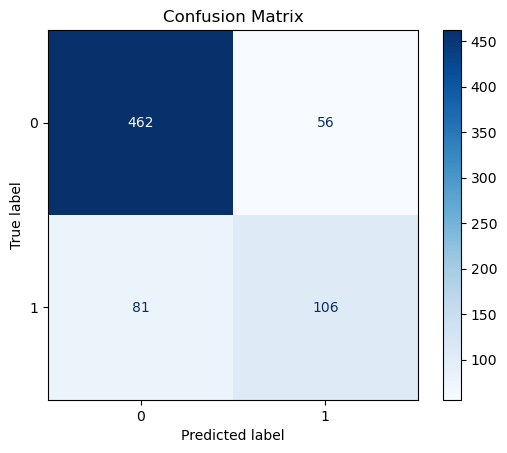

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       518
           1       0.65      0.57      0.61       187

    accuracy                           0.81       705
   macro avg       0.75      0.73      0.74       705
weighted avg       0.80      0.81      0.80       705

****************************************************************************************************
KNN Model 3 Evaluation


<Figure size 800x600 with 0 Axes>

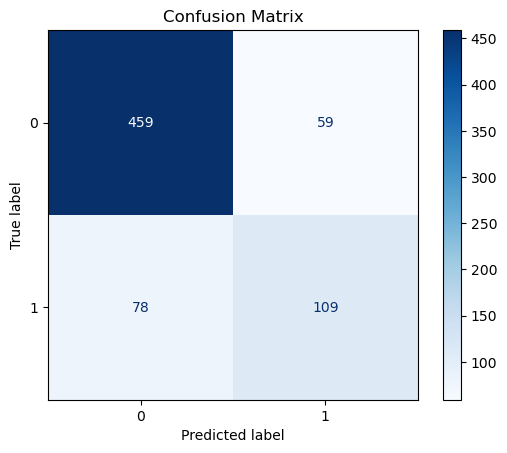

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       518
           1       0.65      0.58      0.61       187

    accuracy                           0.81       705
   macro avg       0.75      0.73      0.74       705
weighted avg       0.80      0.81      0.80       705



In [149]:
# Evaluating
print('KNN Model 2 Evaluation')
evaluating(y_pred_knn_m2,y_test_m2) 

print('*'*100)
print('KNN Model 3 Evaluation')
evaluating(y_pred_knn_m3,y_test_m3) 

There is a slight decrease but almost same performance compared with Model 2. 

**Conclusion**  

Therefore, without further testing, it is hard to decide whether or not to include these two features. However, since the model should reflect on something that is related to the company major business, some features or some created features will be included. 

### Model 4 - Average service price, will it increase the performance?

If I were a customer, I would leave if the price is unaffordable. That is the reason this column is made. By the way, Fido is literally giving me super expensive 'offers' even if I have been with them for 8 years now... Maybe it is time to at least show them I have the intention to leave. 

In [150]:
churn_v2['Total # Service'] = churn_v2[['Phone Service','Internet Service','# of Add-on Phone','# of Add-on Internet']].sum(axis=1) # Row sum
churn_v2['Average Service Price'] = churn_v2['Monthly Charges']/churn_v2['Total # Service']
churn_v2['Average Service Price - Internet/Phone'] = churn_v2['Monthly Charges']/(churn_v2['Phone Service'] + churn_v2['Internet Service'])

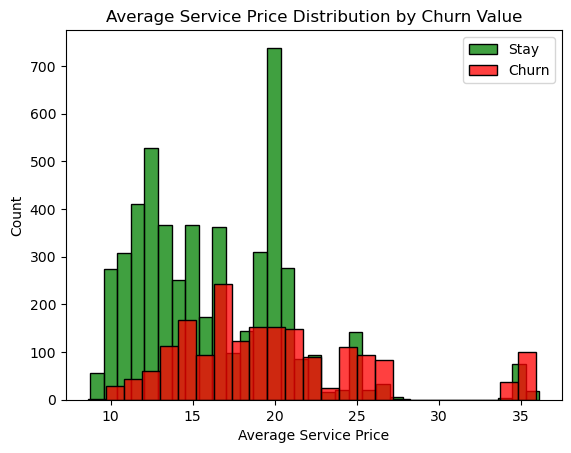

In [151]:
figaa, axaa = plt.subplots()
sns.histplot(data = churn_v2[churn_v2['Churn Value']==0], x='Average Service Price', color = 'green', label='Stay')
sns.histplot(data = churn_v2[churn_v2['Churn Value']==1], x='Average Service Price', color = 'red', label='Churn')
plt.title('Average Service Price Distribution by Churn Value')
axaa.legend();

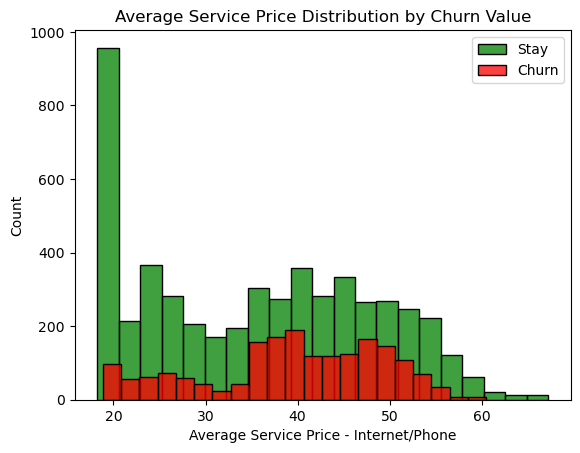

In [152]:
figbb, axbb = plt.subplots()
sns.histplot(data = churn_v2[churn_v2['Churn Value']==0], x='Average Service Price - Internet/Phone', color = 'green', label='Stay')
sns.histplot(data = churn_v2[churn_v2['Churn Value']==1], x='Average Service Price - Internet/Phone', color = 'red', label='Churn')
plt.title('Average Service Price Distribution by Churn Value')
axbb.legend();

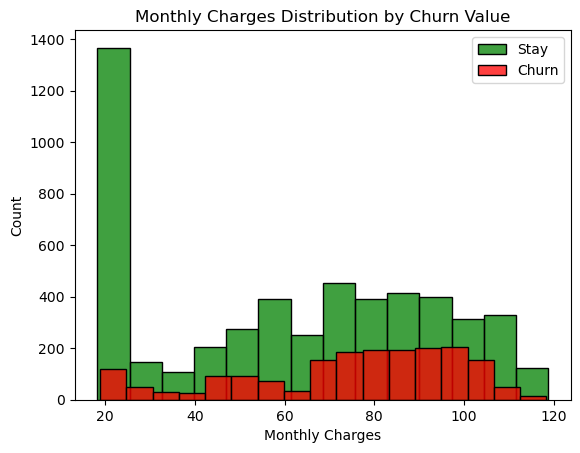

In [153]:
figc

The above two visualizations shows `Monthly Charges` and `Average Service Price` does have different distributions. 

In [154]:
# Feature & Target Split
X_m4 = churn_v2[['Tenure Months','Senior Citizen', 'Dependents','Contract', 'Monthly Charges', 'CLTV','Average Service Price']]
y_m4 = churn_v2['Churn Value']

# Train Test Split
X_train_m4, X_test_m4, y_train_m4, y_test_m4 = train_test_split(X_m4, y_m4, test_size=0.1, stratify=y_m4, random_state=1144)

# Define numeric & categorical col
numeric_col_m4 = ['Tenure Months','Monthly Charges','CLTV','Average Service Price']
categorical_col_m4= ['Senior Citizen', 'Dependents','Contract']

#### Logistic Regression

In [155]:
# Define grid search parameters
param_grid_lgr_m4 = {
    'classifier__class_weight':['balanced',None],
    'classifier__C':[0.1, 0.5, 1,1.5,0.01,5],
}

# Tuning
preprocessor_lgr_m4 = param_tuning(X_train_m4,y_train_m4, LogisticRegression(),param_grid_lgr_m4,cat_col=categorical_col_m4,num_col=numeric_col_m4)

Best parameters found:  {'classifier__C': 0.5, 'classifier__class_weight': None}


In [156]:
# Training & testing
model_lgr_m4 = LogisticRegression(
                        C=0.5, 
                        class_weight = None,
                                        )
y_pred_lgr_m4 = testing(X_train_m4,y_train_m4,X_test_m4,y_test_m4, model=model_lgr_m4, preprocessor=preprocessor_lgr_m4)

Logistic Regression Model 3 Evaluation


<Figure size 800x600 with 0 Axes>

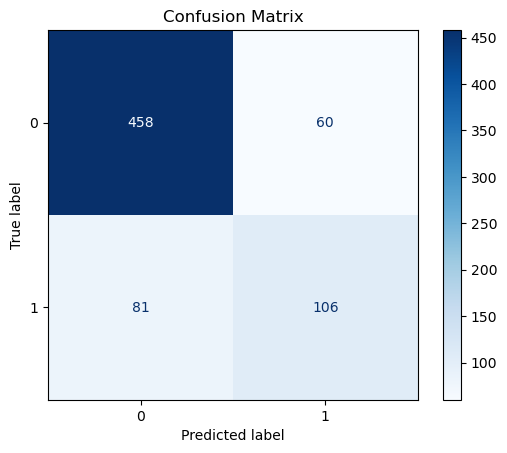

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       518
           1       0.64      0.57      0.60       187

    accuracy                           0.80       705
   macro avg       0.74      0.73      0.73       705
weighted avg       0.79      0.80      0.80       705

****************************************************************************************************
Logistic Regression Model 4 Evaluation


<Figure size 800x600 with 0 Axes>

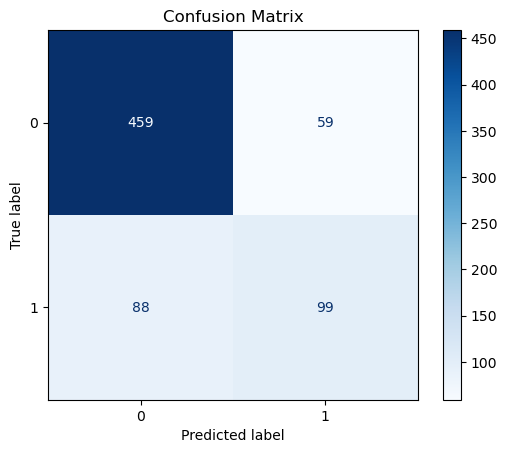

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       518
           1       0.63      0.53      0.57       187

    accuracy                           0.79       705
   macro avg       0.73      0.71      0.72       705
weighted avg       0.78      0.79      0.79       705



In [157]:
print('Logistic Regression Model 3 Evaluation')
evaluating(y_pred_lgr_m3,y_test_m3) 

print('*'*100)
print('Logistic Regression Model 4 Evaluation')
evaluating(y_pred_lgr_m4,y_test_m4) 

#### KNN

In [158]:
# Define grid search parameters
param_grid_knn_m4 = {
    'classifier__n_neighbors':[5,15,20,25,30,50,100],
    'classifier__weights':['uniform','distance'],
}

# Tuning
preprocessor_knn_m4 = param_tuning(X_train_m4,y_train_m4, KNeighborsClassifier(),param_grid_knn_m4,cat_col=categorical_col_m4,num_col=numeric_col_m4)

Best parameters found:  {'classifier__n_neighbors': 25, 'classifier__weights': 'uniform'}


In [159]:
# Training & testing
model_knn_m4  =KNeighborsClassifier(
                        n_neighbors=25, 
                        weights = 'uniform',
                                        )
y_pred_knn_m4 = testing(X_train_m4,y_train_m4,X_test_m4,y_test_m4, model=model_knn_m4, preprocessor=preprocessor_knn_m4)

KNN Model 2 Evaluation


<Figure size 800x600 with 0 Axes>

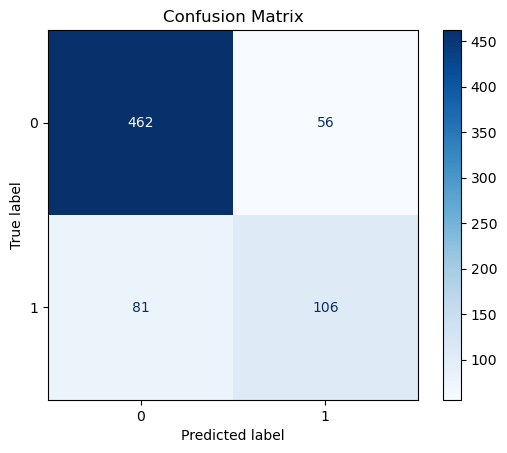

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       518
           1       0.65      0.57      0.61       187

    accuracy                           0.81       705
   macro avg       0.75      0.73      0.74       705
weighted avg       0.80      0.81      0.80       705

****************************************************************************************************
KNN Model 4 Evaluation


<Figure size 800x600 with 0 Axes>

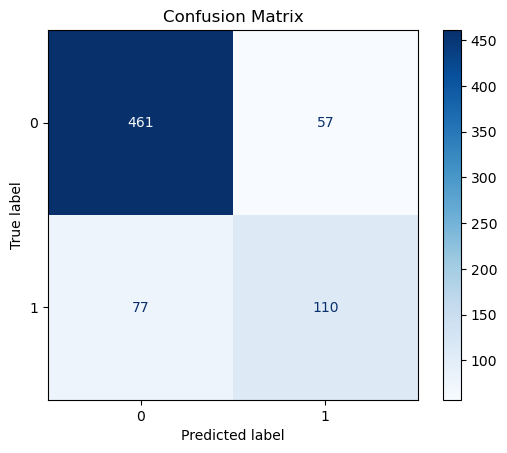

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       518
           1       0.66      0.59      0.62       187

    accuracy                           0.81       705
   macro avg       0.76      0.74      0.75       705
weighted avg       0.80      0.81      0.81       705



In [160]:
# Evaluation
print('KNN Model 2 Evaluation')
evaluating(y_pred_knn_m2,y_test_m2) 

print('*'*100)
print('KNN Model 4 Evaluation')
evaluating(y_pred_knn_m4,y_test_m4) 

#### Random Forest - I guess it does not hurt to give it a try

In [161]:
# Define grid search parameters
from sklearn.ensemble import RandomForestClassifier
param_grid_rmf_m4 = {
    'classifier__n_estimators':[50,100,150,200],
    'classifier__class_weight':['balanced',None]
}

# Tuning
preprocessor_rfm_m4 = param_tuning(X_train_m4,y_train_m4, RandomForestClassifier(),param_grid_rmf_m4,cat_col=categorical_col_m4,num_col=numeric_col_m4)

Best parameters found:  {'classifier__class_weight': None, 'classifier__n_estimators': 100}


In [162]:
model_rfm_m4  =RandomForestClassifier(
                        n_estimators = 200, 
                        class_weight = 'balanced'
                                        )
y_pred_rfm_m4 = testing(X_train_m4,y_train_m4,X_test_m4,y_test_m4, model=model_rfm_m4, preprocessor=preprocessor_rfm_m4)

RFM Model 4 Evaluation


<Figure size 800x600 with 0 Axes>

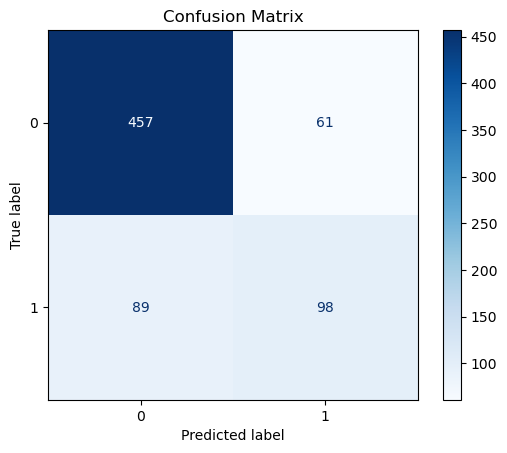

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       518
           1       0.62      0.52      0.57       187

    accuracy                           0.79       705
   macro avg       0.73      0.70      0.71       705
weighted avg       0.78      0.79      0.78       705



In [163]:
print('RFM Model 4 Evaluation')
evaluating(y_pred_rfm_m4,y_test_m4)

**Conclusion** 

By adding `Average Service Price` there is a slight to no increase in both models. In this case model 4 of Logistic Regression is chosen as the final model, as it is the most easiest to interpret.

## Final Model

In [164]:
from sklearn.preprocessing import FunctionTransformer

def service_transformer(X_ms, monthly_charge_col='Monthly Charges'): # From ChatGPT
    """
    Transform function to compute the service transformed value based on the monthly_charge column
    from the current DataFrame.
    
    Parameters:
    - X: DataFrame containing the service columns and the monthly charge column
    - monthly_charge_col: Column name for the monthly charges

    Returns:
    - DataFrame with the original columns and the transformed values
    """
    # Extract the monthly charge column from the DataFrame
    monthly_charge = X_ms[monthly_charge_col]
    
    # Calculate the transformed value
    transformed = monthly_charge / X_ms.drop(columns=[monthly_charge_col]).sum(axis=1)
    
    # Combine the original data with the transformed values
    result_df = X_ms[[monthly_charge_col]].copy()
    result_df['Service Transformed'] = transformed
    
    return result_df






def yes_no_transformer(df):
    return df.replace({'No':0,'Yes':1, 
                       'Fiber optic':1, 'DSL':1,
                       'No internet service':0, 'No phone service':0})






# Transformer Function build up
service_t = FunctionTransformer(
    func=lambda X: service_transformer(X),
    validate=False
)


yes_no = FunctionTransformer(yes_no_transformer, kw_args={})

In [165]:
service_col = ['Internet Service','Phone Service','Multiple Lines', 
               'Online Security','Online Backup',
                'Device Protection','Tech Support',
                'Streaming TV','Streaming Movies','Monthly Charges']
num_col = ['Tenure Months','CLTV']
cat_col= ['Senior Citizen', 'Dependents','Contract']

# Transforming
# Encoding
service_tr = Pipeline(
    steps = [('y/s transformer', yes_no),
            ('sum',service_t),
            ("scaler", StandardScaler())
            ])

categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first',sparse_output=False)),
            ("scaler", StandardScaler())
            ]
)
# Scaling
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])


preprocessor= ColumnTransformer(
            transformers=[
                ('service',service_tr, service_col),
                ('cat', categorical_transformer, cat_col),
                ('num', numeric_transformer, num_col)
]
)


# Model & Pipeline Creation
model= LogisticRegression(
                        C=0.5, 
                        class_weight = None,
                                        )
model_lgr_f= Pipeline(
        steps=[("preprocessor_t", preprocessor), ('model',model)]
                    )

In [166]:
# Transforming
X_f = churn_org[service_col + num_col + cat_col]
y_f = churn_org['Churn Value']
# X_f.shape
# X_transformed = preprocessor.fit_transform(X_f)
# X_transformed.shape[1]==8 # Sanity check, get 8 columns -> Pass

# Model Training
model_lgr_f.fit(X_f,y_f)

Pipeline(steps=[('preprocessor_t',
                 ColumnTransformer(transformers=[('service',
                                                  Pipeline(steps=[('y/s '
                                                                   'transformer',
                                                                   FunctionTransformer(func=<function yes_no_transformer at 0x0000011D65DEEEE0>,
                                                                                       kw_args={})),
                                                                  ('sum',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000011D65E29280>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Internet Service',
                                                   'Phone Service',
                                                   'Multiple Line...
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Monthly Charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Senior Citizen',
                                                   'Dependents', 'Contract']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure Months', 'CLTV'])])),
                ('model', LogisticRegression(C=0.5))])

In [167]:
# Prediction
synthetic_data = pd.DataFrame({
    'Senior Citizen': ['No', 'Yes'],
    'CLTV': [3239, 3398],
    'Dependents': ['No', 'No'],
    'Tenure Months': [0, 24],
    'Phone Service': ['Yes', 'Yes'],
    'Multiple Lines': ['No', 'Yes'],
    'Internet Service': ['Fiber optic', 'DSL'],
    'Online Security': ['Yes', 'Yes'],
    'Online Backup': ['Yes', 'No'],
    'Device Protection': ['No', 'Yes'],
    'Tech Support': ['No', 'No'],
    'Streaming TV': ['No', 'Yes'],
    'Streaming Movies': ['No', 'Yes'],
    'Contract': ['Month-to-month', 'Two year'],
    'Monthly Charges': [70, 55.75],
})

In [168]:
X_p=synthetic_data[service_col + num_col + cat_col]
model_lgr_f.predict(X_p)


array([1, 0], dtype=int64)

In [169]:
names = ['Tenure Months', 'Senior Citizen', 'Dependents', 'Contract_TwoYear', 'Contract_OneYear',
       'Monthly Charges', 'CLTV', 'Average Service Price'] 

# TwoYear is before OneYear, because it is first met
# churn_org['Contract'].unique() 
# array(['Month-to-month', 'Two year', 'One year'], dtype=object)

coefficient = model.coef_.tolist()[0]

model_coef = pd.DataFrame({'coef':coefficient},index=names).T
model_coef

,Tenure Months,Senior Citizen,Dependents,Contract_TwoYear,Contract_OneYear,Monthly Charges,CLTV,Average Service Price
coef,0.765886,0.168876,0.104869,-0.615171,-0.384318,-0.759141,-0.787225,0.02884


In [170]:
churn_v2['Tenure Months'].mean()

32.37114865824223

## Discussion

### Add in Churn Score Example on Logistic Regression
Since `Churn Score` is highly correlated, Model 4 is modified by including `Churn Score` to see how much of an increase it can give.

In [171]:
# Feature & Target Split
X_m5 = churn_v2[['Tenure Months','Senior Citizen', 'Dependents','Contract', 'Monthly Charges', 'CLTV','Average Service Price','Churn Score']]
y_m5 = churn_v2['Churn Value']

# Train Test Split
X_train_m5, X_test_m5, y_train_m5, y_test_m5 = train_test_split(X_m5, y_m5, test_size=0.1, stratify=y_m5, random_state=1144)

# Define numeric & categorical col
numeric_col_m5 = ['Tenure Months','Monthly Charges','CLTV','Average Service Price','Churn Score']
categorical_col_m5= ['Senior Citizen', 'Dependents','Contract']

In [172]:
param_grid_lgr_m5 = {
    'classifier__class_weight':['balanced',None],
    'classifier__C':[0.1, 0.5, 1,1.5,0.01,5],
}

# Tuning
preprocessor_lgr_m5 = param_tuning(X_train_m5,y_train_m5, LogisticRegression(),param_grid_lgr_m5,cat_col=categorical_col_m5,num_col=numeric_col_m5)

Best parameters found:  {'classifier__C': 0.01, 'classifier__class_weight': 'balanced'}


In [173]:
# Training
model_lgr_m5 = LogisticRegression(
                        C=0.01, 
                        class_weight = 'balanced',
                                        )
y_pred_lgr_m5 = testing(X_train_m5,y_train_m5,X_test_m5,y_test_m5, model=model_lgr_m5, preprocessor=preprocessor_lgr_m5)

Logistic Regression Model 3 Evaluation


<Figure size 800x600 with 0 Axes>

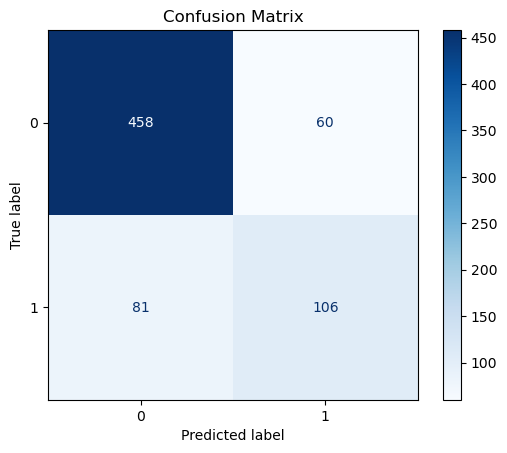

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       518
           1       0.64      0.57      0.60       187

    accuracy                           0.80       705
   macro avg       0.74      0.73      0.73       705
weighted avg       0.79      0.80      0.80       705

****************************************************************************************************
Logistic Regression Model 5 Evaluation


<Figure size 800x600 with 0 Axes>

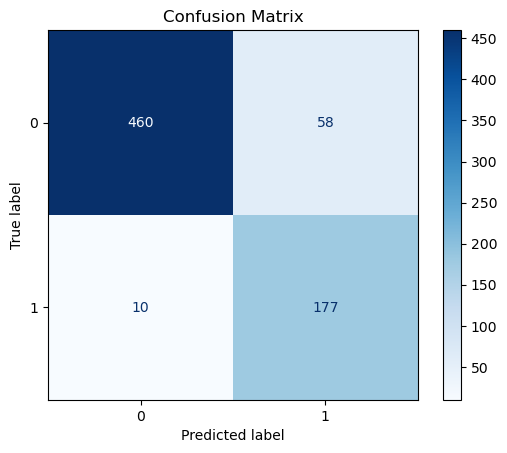

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       518
           1       0.75      0.95      0.84       187

    accuracy                           0.90       705
   macro avg       0.87      0.92      0.89       705
weighted avg       0.92      0.90      0.91       705



In [174]:
# Evaluating
print('Logistic Regression Model 3 Evaluation')
evaluating(y_pred_lgr_m3,y_test_m3) 

print('*'*100)
print('Logistic Regression Model 5 Evaluation')
evaluating(y_pred_lgr_m5,y_test_m5) 

`Churn Score` is indeed very powerful.. It is also worth to point out that this model is the only case where the choice of hyperparameter is indeed based on optimizing recall rather than accuracy. 

In this case if `CLTV` and `Average Service Price` are removed, and the performance was not changed. Actually, `Average Service Price` is not useful in Model 4 as well.. The reason why it is included is that, the model needs to have some parameters of the services used by customers. Otherwise, it is indicating that the stay or the leave of the customer, this decision is not influeced by the kind of service the company provides. 

### CLTV

CLTV has a relatively strong power in this model. The below is the common formula to calculate CLTV:
$$CLTV=Average \space Purchase \space Value×Purchase \space Frequency×Customer \space Lifespan×Profit \space Margin$$

The only unknown here is the profit margin but this can be found by making a model?

One thing that could have been included in the project is to calculate the actual loss made by the model. For all the false negatives, a sum of CLTV can be found, and this can be added as an evaluation parameter. The smaller the loss is, the better the model. This can be achieved relatively easily by joining the y_pr to the original dataframe first, then identifying False Negatives, then find the sum. 

### Do we think we can build an important feature by existing columns?

There are three things that can influence the performance of a model: **the type of the model**, **hyperparamters**, and **feature selections**. 

**The type of the model** in this project does not seem to impact the model too much. However it was shown in other projects/assignments that it matters. The change of **hyperparameters** does have a strong impact, and those two factors can be almost best tuned with `GridSearchCV`. 

Lastly, **feature selection** seemed to help as long as the feature added/removed itself has a strong correlation of a target. Sometimes the interactions of the features are important (i.e. adding `Churn Score` immediately boosted the performance), but so far I did not see a way to identify a valuable interaction term. 
